In [1]:
import imageio
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tnrange
import numpy as np
import math

In [2]:
K = 1.6e6
E = 8e4
alpha = 1.0
Q = 7e5
T_0 = 293 # начальная температура
rho = 830
C = 1990
lamb = 0.13
D = 8e-12
R = 8.31


In [3]:
# Регулярный режим
# D = 8e-8
# K = 1.6e6
# E = 8e4

# Двухпериодический режим
# D = 8e-12
# K = 4.6e6
# E = 8.5e4

# Хаос
# D = 8e-12
# K = 1e8
# E = 1.02e5

T_m = T_0 + Q / C # конечная температура
kappa = lamb / (rho * C)
U = (2 * K * lamb / (Q * rho * Q / C) * T_0 / T_m * ((R * T_m * T_m / E) ** 2) * np.exp(-E / (R * T_m))) ** 0.5
beta = R * T_m / E
gamma = R * T_m * T_m / (E * Q / C)
delta_h = kappa / U
delta_r = beta * delta_h
delta_d = D / U
Le = delta_d / delta_h
print(Le, K*np.exp(-E/(R*T_m)), kappa)

print(beta)
print(gamma)

0.00010164307692307692 0.5243573545932608 7.870678694678211e-08
0.06697431972361809
0.1227610577254038


In [4]:
a = 0
b = 3e-2
dz = 1e-4
z_steps = int((b-a) / dz)

theta = 500
dt = 1e-2
t_steps = int(theta / dt)

In [5]:
t_0 = np.zeros(z_steps, dtype=np.float64)
x_0 = np.zeros(z_steps, dtype=np.float64)

for i in range(1):
    t_0[i] = T_m
    x_0[i] = 0
    
for i in range(1, z_steps):
    t_0[i] = T_0
    x_0[i] = 1

In [6]:
def w(x, t):
    return -K * (x ** alpha) * np.exp(-E / (R * t))

In [7]:
f = open("file.txt", "w+")
print(dt)
def explicit_downstream():
    Ts = [t_0]
    Xs = [x_0]
    Ws = []
    
    cur_w = [0] * len(x_0)
    for i in range(len(x_0)):
        cur_w[i] = w(x_0[i], t_0[i])
    
    Ws.append(cur_w)
    
    for cur_iter in range(1, t_steps + 1):
        cur_t = np.zeros(z_steps, dtype=np.float64)
        cur_x = np.zeros(z_steps, dtype=np.float64)
        cur_w = np.zeros(z_steps, dtype=np.float64)
        
        old_t = Ts[-1]
        old_x = Xs[-1]
        
        cur_t[0] = T_m

        for i in range(1, z_steps - 1):
            cur_t[i] = old_t[i] + dt * kappa / (dz ** 2) * (old_t[i + 1] - 2 * old_t[i] + old_t[i - 1]) - Q / C * dt * w(old_x[i], old_t[i])
            cur_x[i] = old_x[i] + dt * D / (dz ** 2) * (old_x[i + 1] - 2 * old_x[i] + old_x[i - 1]) + dt * w(old_x[i], old_t[i])

        cur_t[z_steps - 1] = cur_t[z_steps - 2]
        cur_x[z_steps - 1] = cur_x[z_steps - 2]
        
        cur_w = [0] * len(cur_x)
        for i in range(len(cur_x)):
            cur_w[i] = w(cur_x[i], cur_t[i])
        Ws.append(cur_w)
        
        #print(cur_x, file=f)
        Ts.append(cur_t)
        Xs.append(cur_x)
    f.close()
    return Ts, Xs, Ws

0.01


In [8]:
Ts, Xs, Ws = explicit_downstream()

In [17]:
def build_gif(Ys, name, step=100):
    fig, ax = plt.subplots(figsize=(10,8))
    min_y = np.min(Ys)
    max_y = np.max(Ys)
    ax.set_ylim(0.95*min_y, max_y*1.05)
    x = np.linspace(a, b, num=z_steps)
    line, = ax.plot(x, Ys[0])
 
    def animate(i):
        line.set_ydata(Ys[i])
        return line,
 
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,
 
    ani = animation.FuncAnimation(fig, animate, tnrange(0, t_steps, step), init, blit=True)
    ani.save(name + '.gif', writer='pillow', fps=600)


In [26]:
def build_gif1(Ys, name, step=100):
    fig, ax = plt.subplots(figsize=(15,8))
    min_y = np.min(Ys)
    max_y = np.max(Ys)
    ax.set_ylim(-1, 1)
    x = np.linspace(a, b, num=z_steps)
    line, = ax.plot(x, Ys[0])
 
    def animate(i):
        line.set_ydata(Ys[i])
        return line,
 
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,
 
    ani = animation.FuncAnimation(fig, animate, tnrange(0, t_steps, step), init, blit=True)
    ani.save(name + '.gif', writer='pillow', fps=600)

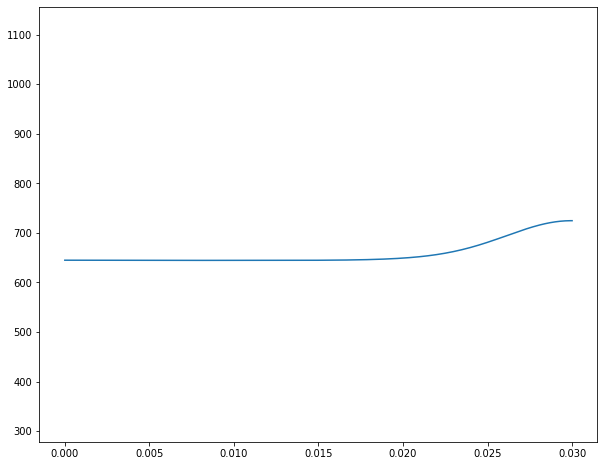

In [23]:
build_gif(Ts, 'T')

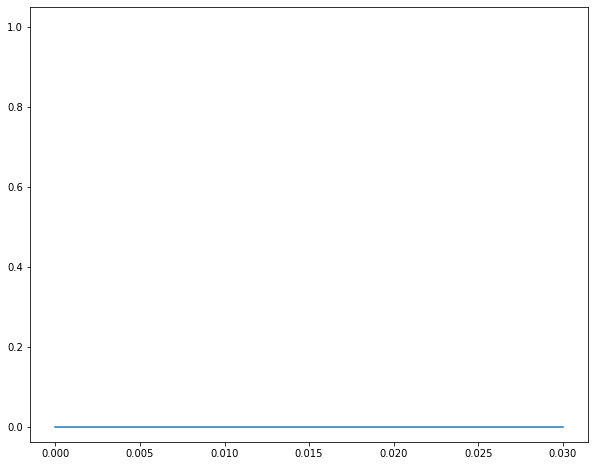

In [24]:
build_gif(Xs, 'X')

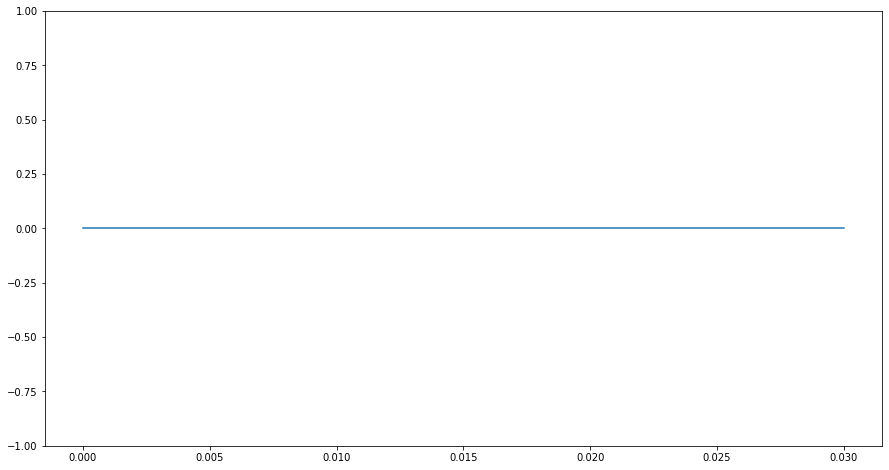

In [27]:
build_gif1(Ws, 'W')

In [38]:
def build_image(Ys, step=100):
    fig, ax = plt.subplots(figsize=(15,8))
    min_y = np.min(Ys)
    max_y = np.max(Ys)
    ax.set_ylim(0.95*min_y, 1.1*max_y)
    x = np.linspace(a, b, num=z_steps)
    line, = ax.plot(x, Ys[0])
    for i in range(0, len(Ys), step):
        ax.plot(x, Ys[i])
#     def animate(i):
#         line.set_ydata(Ys[i])
#         return line,
 
#     def init():
#         line.set_ydata(np.ma.array(x, mask=True))
#         return line,
 
    plt.show()

In [39]:
def build_image1(Ys, step=100):
    fig, ax = plt.subplots(figsize=(15,8))
    min_y = np.min(Ys)
    max_y = np.max(Ys)
    ax.set_ylim(-1, 1)
    x = np.linspace(a, b, num=z_steps)
    line, = ax.plot(x, Ys[0])
    for i in range(0, len(Ys), step):
        ax.plot(x, Ys[i])
#     def animate(i):
#         line.set_ydata(Ys[i])
#         return line,
 
#     def init():
#         line.set_ydata(np.ma.array(x, mask=True))
#         return line,
 
    plt.show()

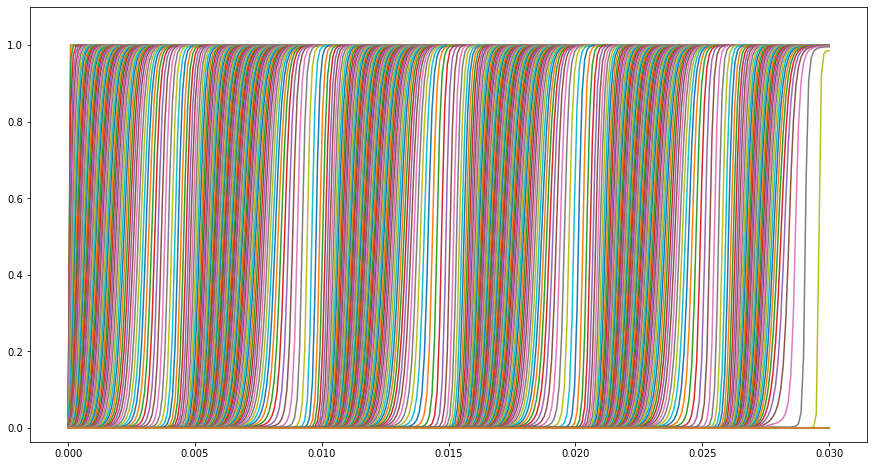

In [40]:
build_image(Xs)

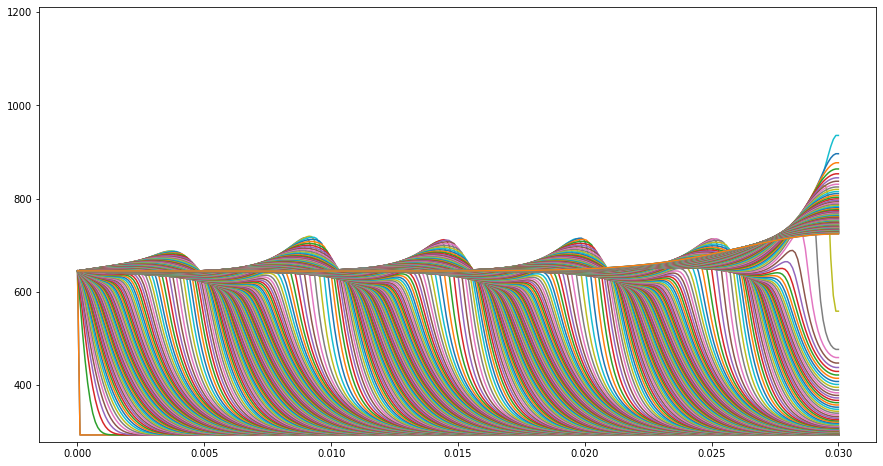

In [42]:
build_image(Ts)

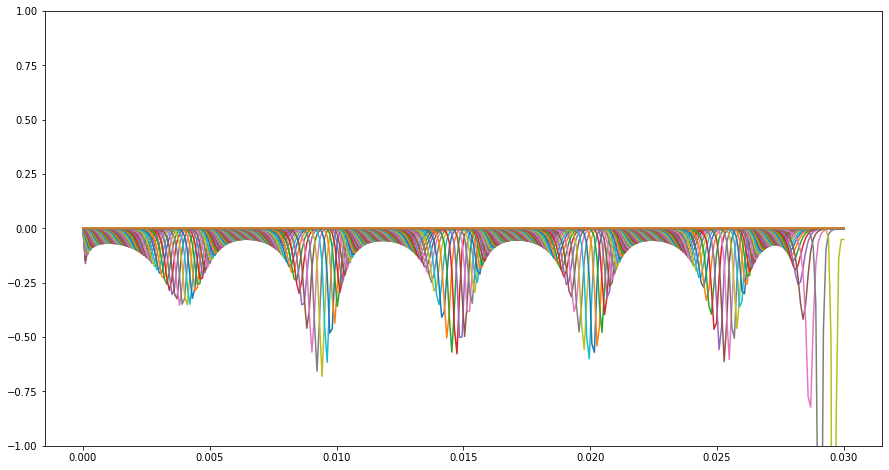

In [43]:
build_image1(Ws)